# Side Quests:
* Is K-Means robust to oscillation phase changes?
    * yes
* Is the signal's inverse fall time (slopyness) related to energy?
    * no, it is a function of detector geometry
* What's the Integrated Charge Signal (signal before electronics)
    * mathematical inverse of electronics calculated
    * signals put through electronics inverse
* What does an energy cut do?
    * cleans up noise and reduces oscillation amplitude relative to signals
* Do decomposition methods work?
    * neither PCA nor Kernel PCA decompose the signal well
* Do other clustering methods find anything interesting?
    * no, DBSCAN and Ward agglomerative clustering don't find anything really new
* What is the makeup of the signals as a function of detector position?
    * calculated and reported
    * a small number of the detectors make up the majority of the data

## Imports

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from numba import jit
import os
from sklearn.cluster import MiniBatchKMeans, KMeans

## Read in data

Figure out how large the file is and read it all in

In [5]:
s = os.stat('Run_00120_00.bin')

In [6]:
N = int((s.st_size - 8)/7033)

In [7]:
N

429600

this is the custom data type used

In [8]:
dt = np.dtype([('header', '33c'), ('wf', '3500h')])

open the file up and read the whole thing in

In [9]:
with open('Run_00120_00.bin', 'rb') as file:
    theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
    file.seek(8)
    data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')

now I need to apply some bit level logic to the data because of the way it's stored

In [10]:
@jit(nopython=True)
def bitLogic(x):
    for i in range(3500):
        x[i] &= 16383
        if x[i]>8191:
            x[i] -= 16384

In [11]:
for j in range(N):
    bitLogic(data['wf'][j])

### shuffling
this is to prevent some sort of bias from selecting data in one portion of the data

In [12]:
@jit(nopython=True)
def scramble(data):
    np.random.shuffle(data)

In [13]:
scramble(data['wf'][:10])
scramble(data['wf'])

In [14]:
X = data['wf'][:100*1000]

## getting amplitudes
This uses the Jordanov and Knoll Trapezoidal filter derived from a derivative of the Moving Windo Deconvolution to extract the maximum

In [15]:
def amplitudes(data):
    ## Get trapezoid filter
    tau = np.int(1250)
    rise = np.int(200)
    top = np.int(100)
    trap = np.empty(3500)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 3500):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)

    # Get amplitudes
    f = np.fft.irfft(np.fft.rfft(data)*trapNew)
    E = np.amax(f, 1, keepdims=True)
    E -= np.mean(f[:,:100], 1, keepdims=True)
    return E

In [16]:
E = amplitudes(X)

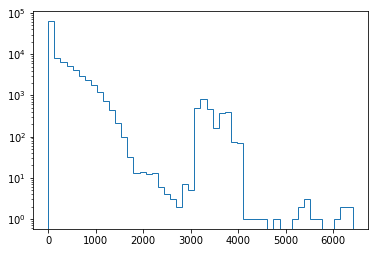

In [17]:
plt.hist(E, bins=50, histtype='step');
plt.yscale('log')

## Normalizing
Because the similarity between the two pulses is a dot product, having different scales will throw off the similarity metrics used in the unsupervised methods. I save the scaling factors to make threshold cuts and to be able to look at energies later

In [18]:
@jit(nopython=True)
def normBatch(data):
    x = data.astype(np.float32)
    for i in range(len(data)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x

In [19]:
x = data['wf'][:20]
x = normBatch(x)

In [20]:
X = normBatch(X)

## Is K-Means robust to oscillation phase changes?

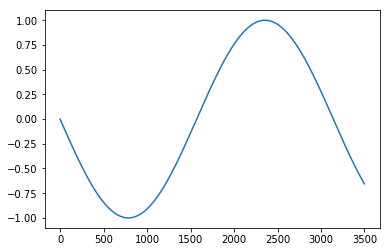

In [27]:
plt.plot(np.sin(np.arange(3500)*0.002+np.pi))

In [29]:
osc = np.empty((10*1000,3500))
for i in range(len(osc)):
    osc[i] = np.sin(np.arange(3500)*0.002+np.random.random()*2.*np.pi)
k = KMeans(n_clusters=2, n_jobs=3).fit(osc)

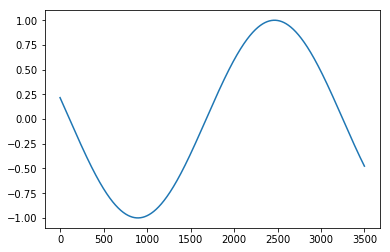

In [33]:
plt.plot(osc[1])

In [38]:
k.transform(osc[1].reshape((1,-1)))

array([[43.64480748, 53.04642106]])

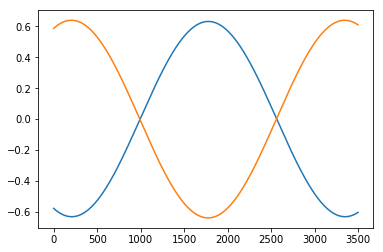

In [31]:
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i])

### Answer: YES! the dot product treats $A* sin(a*x+\phi)$ as $A*sin(a*x)+B*cos(a*x)$

## K means clustering

### How many clusters should I use?

In [22]:
maxClusters = 30
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = KMeans(n_clusters=numClusters, n_jobs=7).fit(X[:1000])
    res2[numClusters-2] = kmean.score(X[:1000])

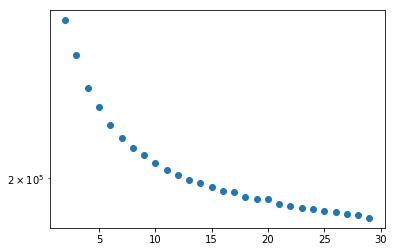

In [23]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

### 10 seems reasonable, so now let's train with 100K wfs

In [24]:
#kmean = KMeans(n_clusters=10, n_init=20, n_jobs=4).fit(X)

In [22]:
import pickle

In [23]:
#with open('kmean', 'wb') as file:
#    pickle.dump(kmean, file)

In [24]:
with open('kmean', 'rb') as file:
    kmean = pickle.load(file)

### Let's get energies for each of the labels so we can check out what the output looks like in terms of steepiness, inverse fall time

In [25]:
clusterIDs = kmean.labels_

In [26]:
clusterE = [np.array([E[j] for j in range(len(X)) if clusterIDs[j]==i]) for i in range(kmean.cluster_centers_.shape[0])]

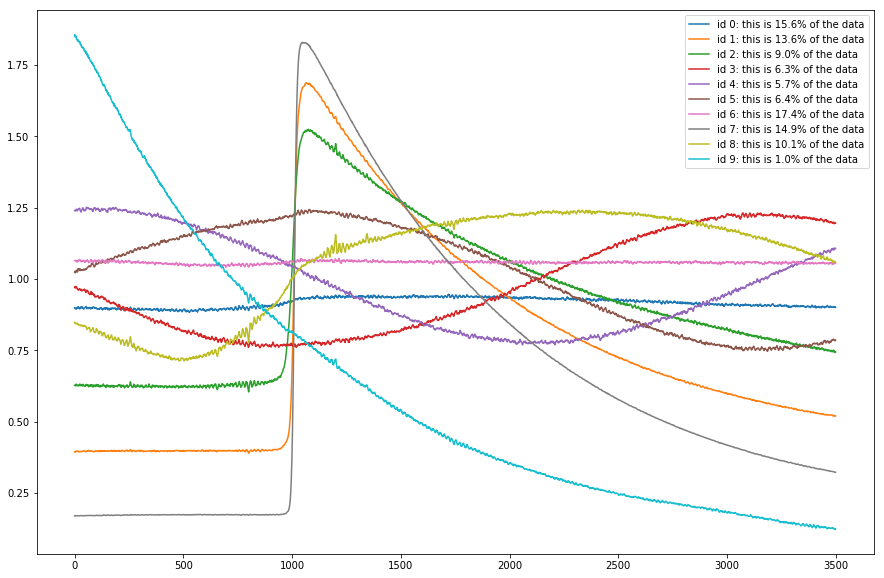

In [28]:
fig = figure(figsize=(15,10))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(np.around(100*len(clusterE[i])/len(X),1))+'% of the data')
legend()

### Now I want to histogram the two different pulses and see if they differ in energies
The ids I want are 6, 2, 9

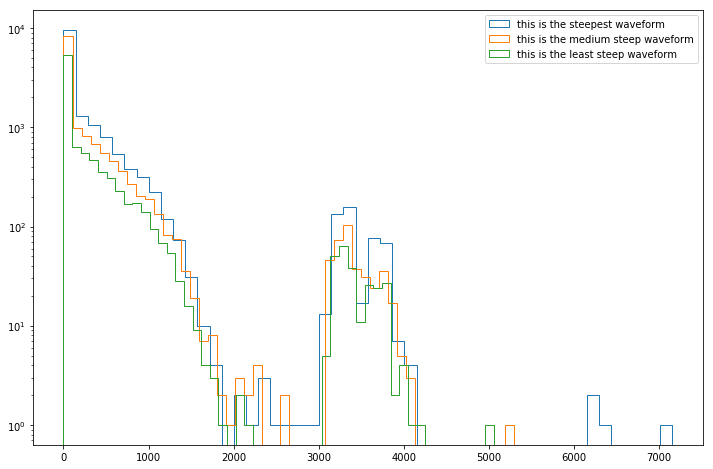

In [30]:
f = plt.figure(figsize=(12,8))
plt.hist(clusterE[7], bins=50, histtype='step', label='this is the steepest waveform')
plt.hist(clusterE[1], bins=50, histtype='step', label='this is the medium steep waveform')
plt.hist(clusterE[2], bins=50, histtype='step', label='this is the least steep waveform')

plt.yscale('log')
plt.legend();

## What's the difference between the energy spectra of the pulsy shapes and the total spectra?

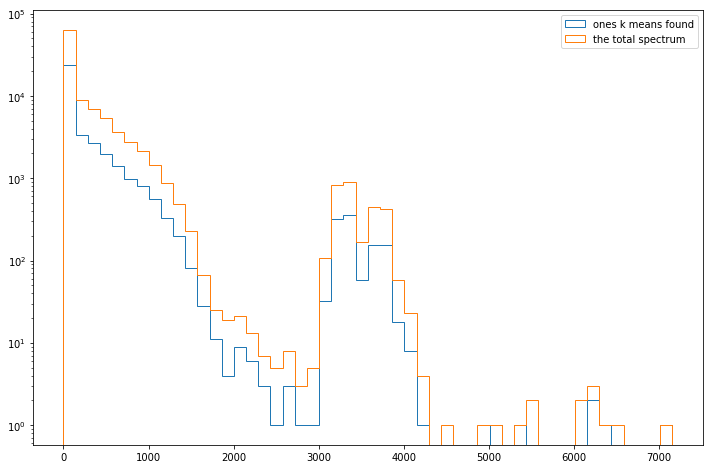

In [34]:
f = plt.figure(figsize=(12,8))
plt.hist(np.append(clusterE[7],np.append(clusterE[2],clusterE[1])), bins=50, histtype='step', label='ones k means found');
plt.hist(np.array([item for sublist in clusterE for item in sublist]),bins=50, histtype='step', label='the total spectrum');
#plt.hist(np.array([clusterE[i] for i in range(7) if i!=1 and i!=4]).flatten(), bins=50, histtype='step', label='ones k means didn\'t founded');
plt.yscale('log')
plt.legend();

## Let's get a integrated charge from this sucker

Now I want to apply the $\text{RC}^2-\text{CR}$ shaper to undo what the electronics does to the signal to get an integrated charge pulse. 

In [35]:
@jit(nopython=True)
def rc2_cr(wf):
    wf2 = np.empty(3500)
    length = len(wf2)
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;    
    zrc1 = np.zeros(2)
    zcr = np.zeros(2)
    zcharge = np.zeros(2)
    zrc2 = wf[:2].copy()
    for i in range(length):
        zrc2[i%2] = wf[i]
        
        zrc1[i%2] = (zrc2[i%2] - zrc2[(i+1)%2])/alpha_rc2 + zrc2[(i+1)%2]
        zcr[i%2] = (zrc1[i%2] - zrc1[(i+1)%2])/alpha_rc1 + zrc1[(i+1)%2]
        zcharge[i%2] = (zcr[i%2]/alpha_cr) - zcr[(i+1)%2] + zcharge[(i+1)%2] 

        wf2[i] = zcharge[i%2]
    
    return wf2

In [36]:
wf1 = kmean.cluster_centers_[7] # this is the most steep
wf2 = kmean.cluster_centers_[2] # this is the medium steep
wf3 = kmean.cluster_centers_[1] # this is the least steep

wf1 -= np.mean(wf1[:200])
wf2 -= np.mean(wf2[:200])
wf3 -= np.mean(wf3[:200])

ctrZ1 = rc2_cr(wf1)
ctrZ2 = rc2_cr(wf2)
ctrZ3 = rc2_cr(wf3)

ctrZ1 /= np.amax(ctrZ1)
ctrZ2 /= np.amax(ctrZ2)
ctrZ3 /= np.amax(ctrZ2)

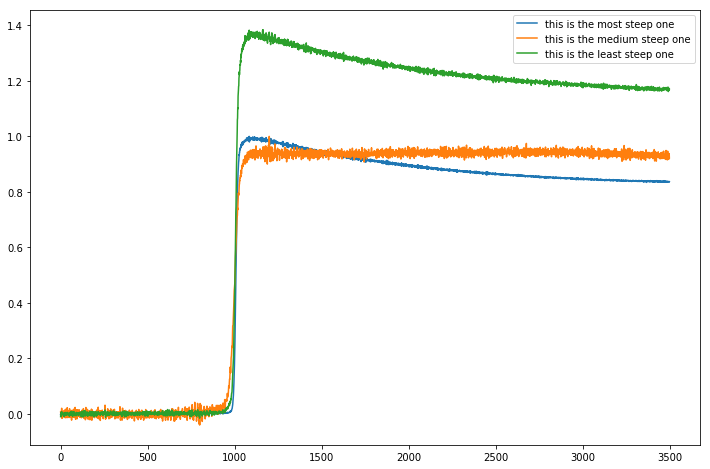

In [38]:
fig = figure(figsize=(12,8))
plot(ctrZ1, label='this is the most steep one')
plot(ctrZ2, label='this is the medium steep one')
plot(ctrZ3, label='this is the least steep one')

legend();

Now I can look at distributions around each point

## Let's run with more clusters and see what happens

In [64]:
X = normBatch(X)

In [65]:
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(X)

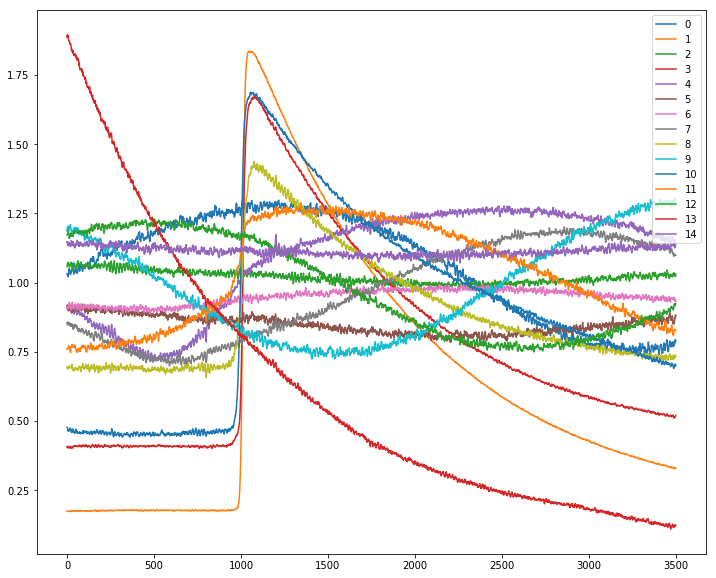

In [66]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

It digs into the noise and finds all the weird oscillations that are going on. It also finds a few different pulse shapes

## Here's with a 200 ADC energy cut

In [69]:
Cutoff = 200
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(np.array([X[i] for i in range(len(X)) if E[i]>Cutoff]))

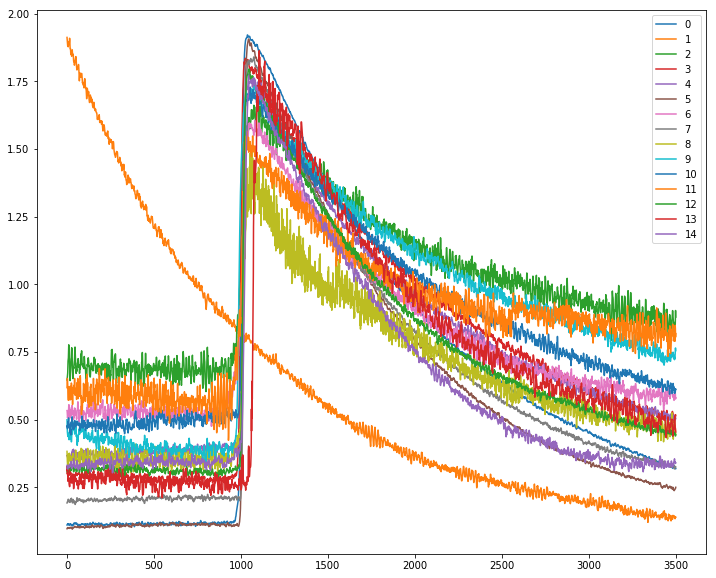

In [70]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

This really cleans up the noise so that you only see the signals and cosmics

## Let's try to find pileup
I do this later in my DNP talk more effectively

In [41]:
Cutoff = 100
k = KMeans(n_clusters=25, n_init=10).fit(np.array([X[i] for i in range(len(X)) if E[i]>Cutoff]))

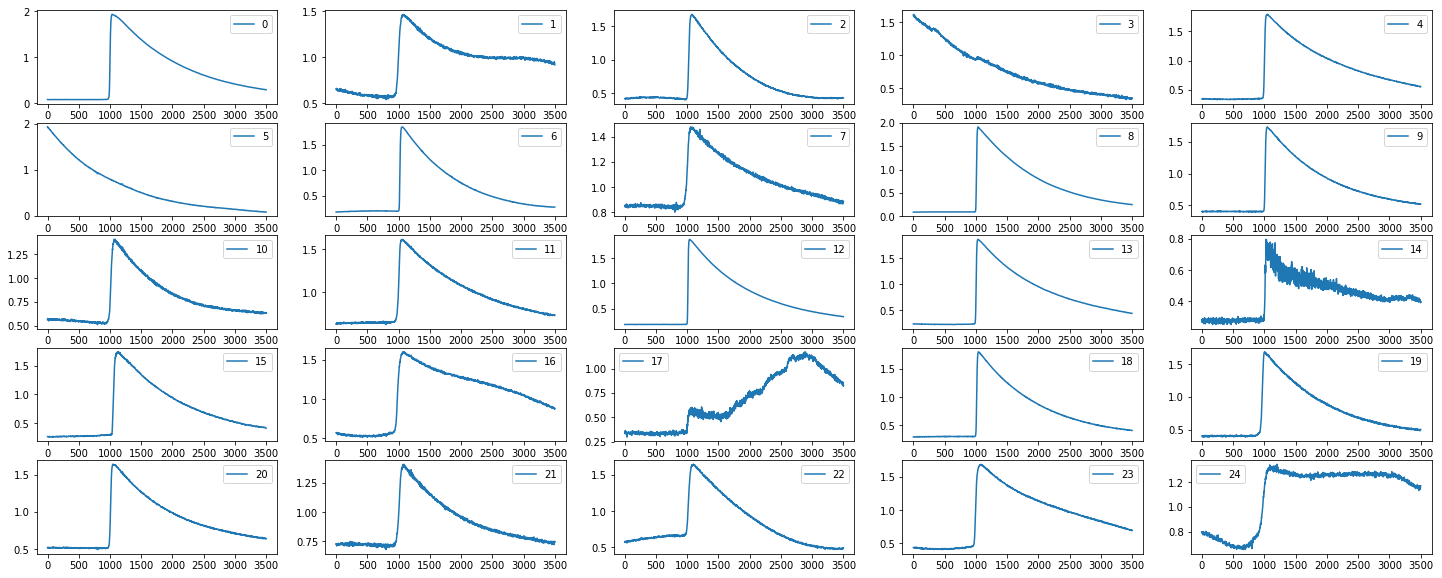

In [42]:
fig = figure(figsize=(25,10))
for i in range(k.cluster_centers_.shape[0]):
    subplot(5,5,i+1)
    plot(k.cluster_centers_[i], label=str(i))
    legend()

None of this looks like obvious pileup, but it does look like some of the stuff Noah has talked about

ID number seven looks interesting, so let's see what's going on there

In [43]:
weird_ones = []
for i in range(len(k.labels_)):
    if k.labels_[i]==17:
        weird_ones.append(X[i])

In [44]:
len(weird_ones)

98

We'll just look at the first 25

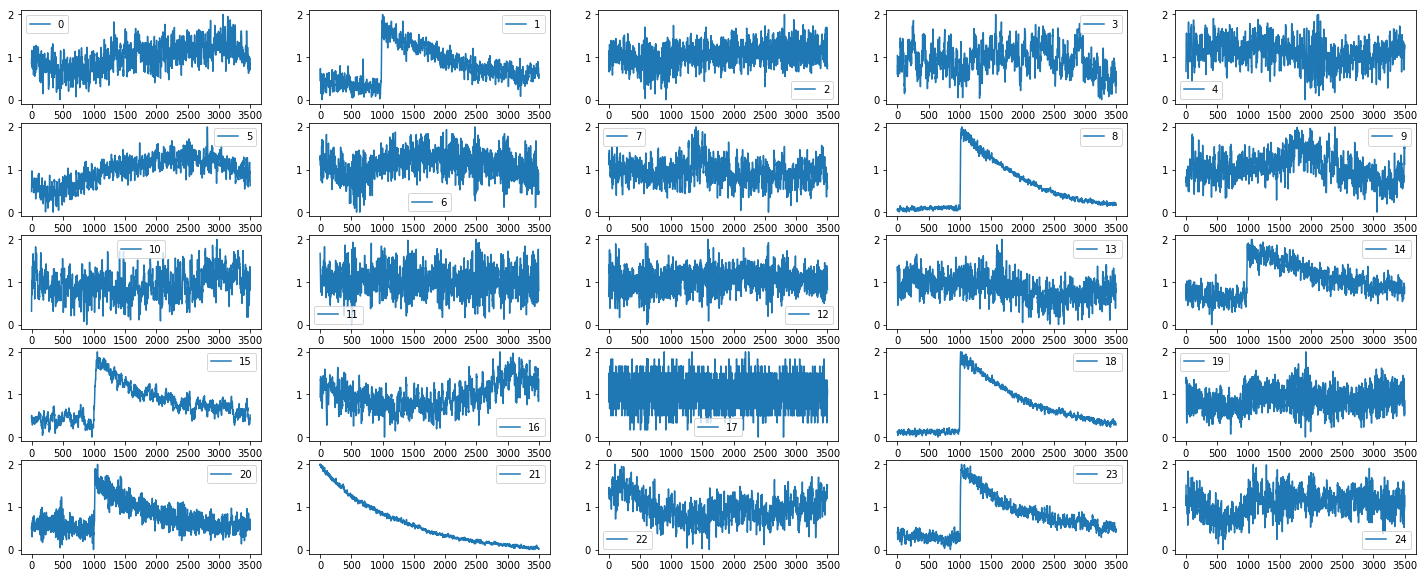

In [45]:
fig = figure(figsize=(25,10))
for i in range(25):
    subplot(5,5,i+1)
    plot(weird_ones[i], label=str(i))
    legend()

## Let's try Dimensionality reduction, other clustering algorithms, etc

### Try PCA on the data - it won't work

In [22]:
from sklearn.decomposition import PCA
from scipy import stats

In [23]:
maxDim = 20
x = X[:10*1000]
x /= np.std(x, 0)
x -= np.mean(x, 0)
res = np.empty(maxDim-1)
pca = PCA(n_components=maxDim)
pca.fit(x)
pca_score = pca.explained_variance_ratio_

for i in range(1,maxDim):
    res[i-1] = 1.0-np.sum(pca_score[:i])

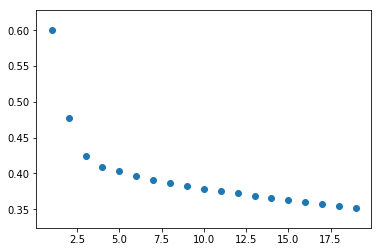

In [24]:
t = np.arange(1,maxDim)
scatter(t, res)

Cannot use PCA to get more than about 30% of the variance in the data, so eh...

Maybe I'll look at clustering them with the OPTIC algorithm

Lol, the OPTIC algorithm is experimental in sklearn, so I'll try kernel trick PCA and spectral clustering

### Maybe Kernel PCA works better?

In [36]:
from sklearn.decomposition import KernelPCA

In [42]:
maxDim = 20
x = X[:10*1000]
x /= np.std(x, 0)
x -= np.mean(x, 0)
res = np.empty(maxDim-1)
pca = KernelPCA(n_components=maxDim, n_jobs=4)
pca.fit(x)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='linear',
          kernel_params=None, max_iter=None, n_components=20, n_jobs=4,
          random_state=None, remove_zero_eig=False, tol=0)

In [43]:
pca_score = pca.lambdas_

for i in range(1,maxDim):
    res[i-1] = 1.0-np.sum(pca_score[:i])

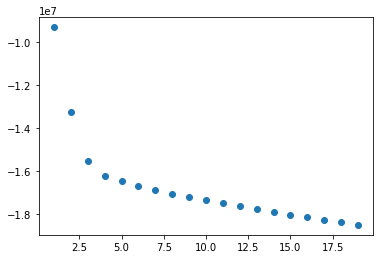

In [44]:
t = np.arange(1,maxDim)
scatter(t, res)

So using the kernel pca with 4 dimensions may be a good reduction to make, but we'll see

Now I'm going to apply spectral clustering and see what it finds as the average pulse shape

Spectral decomposition threw a linear algebra error, so I am trying something else

DBSCAN said all samples were too noisy

In [71]:
from sklearn.cluster import DBSCAN

In [72]:
spectre = DBSCAN(eps=3.5)

This method is taking a heck of a lot longer than k means clustering, so it had better look pretty 

In [73]:
N = 10000

In [74]:
spectre.fit(X[:N])

DBSCAN(algorithm='auto', eps=3.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [75]:
list(set(spectre.labels_))

[0, 1, 2, -1]

In [76]:
numCenters = len(list(set(spectre.labels_))) -1 
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

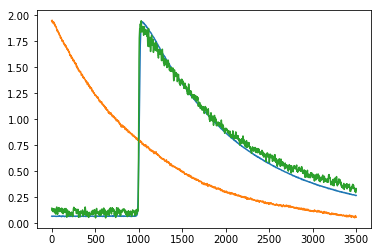

In [77]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

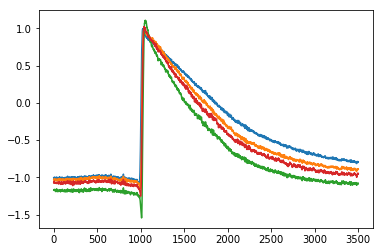

In [52]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
spectre = AgglomerativeClustering(n_clusters=10)

In [ ]:
N = 10000

In [56]:
spectre.fit(X[:N])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8,
                        pooling_func='deprecated')

In [57]:
list(set(spectre.labels_))

[0, 1, 2, 3, 4, 5, 6, 7]

In [58]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

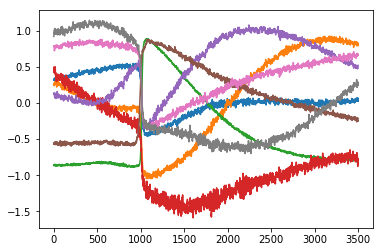

In [59]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

ok, wow this cannot handle the sharp variation at the start of the waveform pulse

In [ ]:
maxClusters = 40
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = Birch(n_clusters=numClusters,  n_jobs=4).fit(X[:1000])
    res2[numClusters-2] = kmean.score(X)

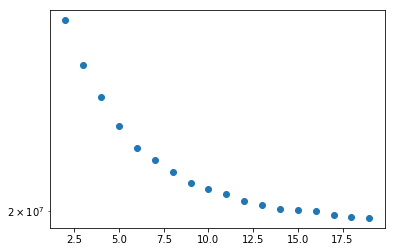

In [30]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
spectre = AgglomerativeClustering(n_clusters=8, linkage='ward')

In [23]:
N = 1000*10

In [ ]:
spectre.fit(X[:N])

In [ ]:
list(set(spectre.labels_))

In [ ]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

In [ ]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [22]:
spectre = AgglomerativeClustering(n_clusters=15, linkage='ward')

In [23]:
N = 1000*10

In [24]:
spectre.fit(X[:N])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=15,
                        pooling_func='deprecated')

In [25]:
list(set(spectre.labels_))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [26]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

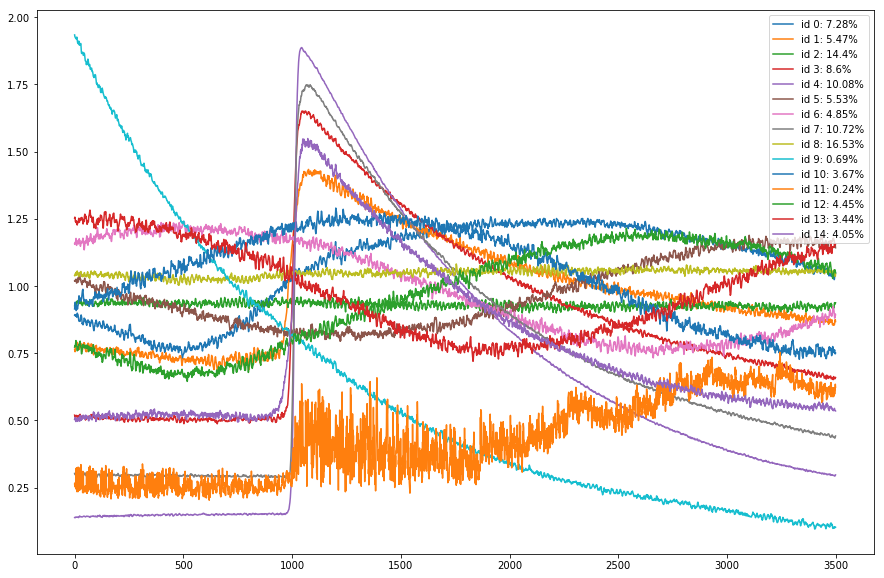

In [93]:
f = plt.figure(figsize=(15,10))
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(np.around(100*spectreCount[i],2))+'%')
plt.legend()

### hmm, let's look at the pixel ids to see what the makeup of the data is geometrically

In [39]:
dh = np.dtype([
    ('result',np.ubyte), ('event id', 'i'), 
    ('board number', 'i4'), ('channel number', 'i4'),
    ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
    ('length', 'i4')])

In [40]:
np.core.records.fromstring?

Signature:
np.core.records.fromstring(
    ['datastring', 'dtype=None', 'shape=None', 'offset=0', 'formats=None', 'names=None', 'titles=None', 'aligned=False', 'byteorder=None'],
)
Docstring:
create a (read-only) record array from binary data contained in
a string
File:      ~/.local/lib/python3.5/site-packages/numpy/core/records.py
Type:      function


In [41]:
headerInfo = np.core.records.fromstring(data['header'].copy(order='C'), dtype=dh ,shape=N)

In [42]:
headerInfo[:10]

rec.array([(1, 0, 1, 1, 18446744073709551346, 226054, 3500),
           (1, 0, 1, 3,                   10, 235820, 3500),
           (1, 0, 1, 4,                  166, 244532, 3500),
           (1, 0, 1, 2,                  196, 253278, 3500),
           (1, 0, 1, 6,                  200, 266394, 3500),
           (1, 0, 1, 5,                  254, 275622, 3500),
           (1, 0, 1, 7,                  910, 284238, 3500),
           (1, 0, 1, 1, 18446744073709550652, 296860, 3500),
           (1, 0, 1, 2, 18446744073709550652, 305648, 3500),
           (1, 0, 1, 3, 18446744073709550652, 317936, 3500)],
          dtype=[('result', 'u1'), ('event id', '<i4'), ('board number', '<i4'), ('channel number', '<i4'), ('req. timestamp', '<u8'), ('cur timestamp', '<u8'), ('length', '<i4')])

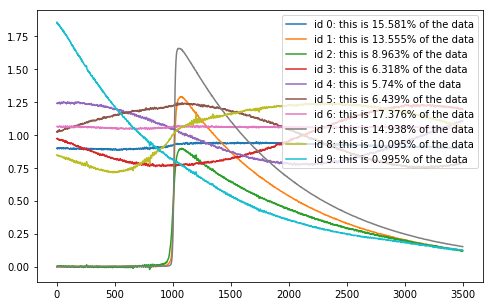

In [43]:
fig = figure(figsize=(8,5))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(100*len(clusterE[i])/len(X))+'% of the data')
legend()

So we want ids 7, 1, 2

In [66]:
from collections import Counter

In [154]:
from enum import unique

In [229]:
idIndexList = [7, 1, 2]
info = []

for i, idIndex in enumerate(idIndexList):
    
    BC = [(headerInfo[j]['board number'],headerInfo[j]['channel number']) for j in range(len(X)) if kmean.labels_[j]==idIndex]
    a
    c = Counter(BC)
    
    total = 0   
    for i, j in c.items() :
        total += j
    
    percCovered = 0.
    percList = c.most_common()
    i = 0
    print('\n\nfor id '+str(idIndex))
    print('(board, channel) ')
    while (percCovered<0.90):
        print(str(percList[i][0])+' makes up '+str(100*np.around(percList[i][1]/total,2)), '%')
        percCovered += percList[i][1]/total
        i += 1




for id 7
(board, channel) 
(4, 3) makes up 31.0 %
(1, 3) makes up 30.0 %
(4, 7) makes up 3.0 %
(1, 4) makes up 2.0 %
(1, 7) makes up 2.0 %
(3, 6) makes up 2.0 %
(2, 1) makes up 2.0 %
(4, 4) makes up 2.0 %
(3, 3) makes up 1.0 %
(0, 4) makes up 1.0 %
(0, 6) makes up 1.0 %
(3, 4) makes up 1.0 %
(1, 6) makes up 1.0 %
(1, 1) makes up 1.0 %
(4, 2) makes up 1.0 %
(4, 5) makes up 1.0 %
(0, 5) makes up 1.0 %
(3, 2) makes up 1.0 %
(0, 7) makes up 1.0 %
(1, 5) makes up 1.0 %
(2, 2) makes up 1.0 %
(0, 2) makes up 1.0 %
(5, 5) makes up 1.0 %


for id 1
(board, channel) 
(1, 3) makes up 31.0 %
(4, 3) makes up 31.0 %
(4, 7) makes up 3.0 %
(1, 4) makes up 2.0 %
(1, 7) makes up 2.0 %
(3, 6) makes up 2.0 %
(4, 4) makes up 2.0 %
(2, 1) makes up 2.0 %
(0, 4) makes up 2.0 %
(3, 3) makes up 1.0 %
(1, 1) makes up 1.0 %
(3, 4) makes up 1.0 %
(4, 5) makes up 1.0 %
(1, 6) makes up 1.0 %
(0, 6) makes up 1.0 %
(0, 5) makes up 1.0 %
(3, 2) makes up 1.0 %
(4, 2) makes up 1.0 %
(4, 1) makes up 1.0 %
(1, 5) makes u

In [96]:
from sklearn.cluster import MiniBatchKMeans

In [119]:
data['wf'].shape

(429600, 3500)

In [120]:
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(data['wf'][:10**4])

In [1]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

NameError: name 'figure' is not defined

# Results are reported below questions at top